# ProgLearn on spoken_digit


In [171]:
import os #read path

import numpy as np

import matplotlib.pyplot as plt 

import librosa #process audio
import librosa.display

import cv2

In [2]:
#proglearn
import pandas as pd
from sklearn.model_selection import train_test_split
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
import time

In [81]:
#cross-validation
from sklearn.model_selection import StratifiedKFold

In [3]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')
AudioData=[] #audio data
X_spec = [] #STFT spectrum by librosa
X_spec_mini = [] #resize to 28*28
Y_number = [] #label of number
Y_speaker = [] #label of speaker

Label_speaker = ['g', 'j', 'l', 'n', 't', 'y'] #first letter of speaker's name

for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i, sr = 8000)
    X = librosa.stft(x,n_fft = 128) #short time fourier transform
    Xdb = librosa.amplitude_to_db(abs(X)) #Convert an amplitude spectrogram to dB-scaled spectrogram
    Xdb_28 = cv2.resize(Xdb, (28, 28))
    y_n = i[0] #number
    y_s = i[2] #first letter of speaker
    
    AudioData.append(x)
    X_spec.append(Xdb)
    X_spec_mini.append(Xdb_28)
    Y_number.append(y_n)
    Y_speaker.append(y_s)


In [4]:
# play the audio (NO.3000 audio, number 9)
import IPython.display as ipd

num = 500
print('Length of the audio (number',Y_number[num],'):',AudioData[num].shape[0],'points') # 8kHz, so 1 s = 8000 digits
ipd.Audio(AudioData[num], rate=sr)

Length of the audio (number 1 ): 1886 points


Text(0.5, 1.0, 'Transformed into 28x28 size')

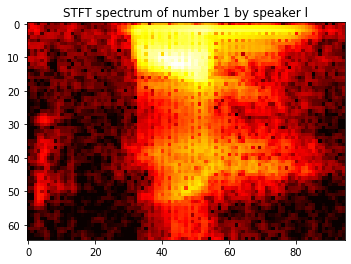

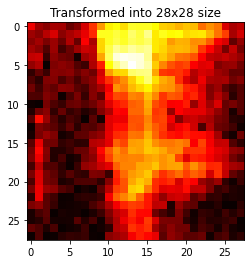

In [136]:
num = 400 #choose from 0 to 2999

fig1,ax1 = plt.subplots()
plt.imshow(X_spec[num], cmap='hot', interpolation='nearest')
plt.title('STFT spectrum of number '+Y_number[num]+' by speaker '+Y_speaker[num])

fig2,ax2 = plt.subplots()
plt.imshow(X_spec_mini[num], cmap='hot', interpolation= 'nearest')
plt.title('Transformed into 28x28 size')

# use the 28x28 for further analysis

In [45]:
# Description
n_audio = 3000
n_speaker = 6
n_per_class = 10
n_per_class_per_speaker = 50

# Flattening
X_all = np.array(X_spec_mini).reshape(n_audio,-1) #(3000, 784)
Y_all = np.array(Y_number).astype(int)#.reshape(n_audio,-1) #(3000, 1) ## it seems that the shape should be (3000,) rather than (3000,1)
Y_all_speaker = np.array(Y_speaker) #(3000,)string

### Cross-validation
- split data into two parts:
    - cross-validation
    - unseen data, test the performance of optimized parameters from cross-validation

In [108]:
# 2400 for cross-validation, 600 for unseen data
X_cross, X_test_final, Y_cross, Y_test_final = train_test_split(X_all, Y_all, test_size=0.2)

df = pd.DataFrame()

train_times_across_tasks = []
inference_times_across_tasks = []

acc = []
num_trees = []

########################################################### initialize proglearn
default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}
default_decider_class = SimpleArgmaxAverage

#n_tree = 20
###########################################################

for n_tree in range(10,31):
    
    accuracies = [] 
    skf = StratifiedKFold(n_splits=6)
    for train_idx, test_idx in skf.split(X_cross, Y_cross):
               
        X_train , X_test = X_cross[train_idx] , X_cross[test_idx]
        Y_train , Y_test = Y_cross[train_idx] , Y_cross[test_idx]

        progressive_learner = ProgressiveLearner(
            default_transformer_class=default_transformer_class,
            default_transformer_kwargs=default_transformer_kwargs,
            default_voter_class=default_voter_class,
            default_voter_kwargs=default_voter_kwargs,
            default_decider_class=default_decider_class,
        )
        train_start_time = time.time()
        progressive_learner.add_task(
            X=X_train,
            y=Y_train,
            task_id=0,
            num_transformers=n_tree,
            transformer_voter_decider_split=[0.67, 0.33, 0],
            decider_kwargs={"classes": np.unique(Y_train)},
        )

        train_end_time = time.time()

        inference_start_time = time.time()
        task_0_predictions = progressive_learner.predict(X_test, task_id=0)
        inference_end_time = time.time()

        accuracies.append(np.mean(task_0_predictions == Y_test))
        train_times_across_tasks.append(train_end_time - train_start_time)
        inference_times_across_tasks.append(inference_end_time - inference_start_time)
        print('n_tree: ',n_tree,', cross-validation.','Current accuracies:',accuracies)
    num_trees.append(n_tree)
    acc.append(np.mean(accuracies))
   

    print('When n_tree is ',n_tree,', the accuracy is ',np.mean(accuracies))

n_tree:  10 , cross-validation. Current accuracies: [0.82]
n_tree:  10 , cross-validation. Current accuracies: [0.82, 0.8325]
n_tree:  10 , cross-validation. Current accuracies: [0.82, 0.8325, 0.8475]
n_tree:  10 , cross-validation. Current accuracies: [0.82, 0.8325, 0.8475, 0.8075]
n_tree:  10 , cross-validation. Current accuracies: [0.82, 0.8325, 0.8475, 0.8075, 0.7925]
n_tree:  10 , cross-validation. Current accuracies: [0.82, 0.8325, 0.8475, 0.8075, 0.7925, 0.8]
When n_tree is  10 , the accuracy is  0.8166666666666665
n_tree:  11 , cross-validation. Current accuracies: [0.82]
n_tree:  11 , cross-validation. Current accuracies: [0.82, 0.7875]
n_tree:  11 , cross-validation. Current accuracies: [0.82, 0.7875, 0.8375]
n_tree:  11 , cross-validation. Current accuracies: [0.82, 0.7875, 0.8375, 0.8125]
n_tree:  11 , cross-validation. Current accuracies: [0.82, 0.7875, 0.8375, 0.8125, 0.825]
n_tree:  11 , cross-validation. Current accuracies: [0.82, 0.7875, 0.8375, 0.8125, 0.825, 0.83]
Wh

n_tree:  25 , cross-validation. Current accuracies: [0.8125, 0.825, 0.87, 0.8575, 0.8425, 0.845]
When n_tree is  25 , the accuracy is  0.8420833333333332
n_tree:  26 , cross-validation. Current accuracies: [0.835]
n_tree:  26 , cross-validation. Current accuracies: [0.835, 0.8825]
n_tree:  26 , cross-validation. Current accuracies: [0.835, 0.8825, 0.865]
n_tree:  26 , cross-validation. Current accuracies: [0.835, 0.8825, 0.865, 0.84]
n_tree:  26 , cross-validation. Current accuracies: [0.835, 0.8825, 0.865, 0.84, 0.84]
n_tree:  26 , cross-validation. Current accuracies: [0.835, 0.8825, 0.865, 0.84, 0.84, 0.8325]
When n_tree is  26 , the accuracy is  0.8491666666666665
n_tree:  27 , cross-validation. Current accuracies: [0.855]
n_tree:  27 , cross-validation. Current accuracies: [0.855, 0.8575]
n_tree:  27 , cross-validation. Current accuracies: [0.855, 0.8575, 0.85]
n_tree:  27 , cross-validation. Current accuracies: [0.855, 0.8575, 0.85, 0.845]
n_tree:  27 , cross-validation. Current 

([<matplotlib.axis.XTick at 0x1f04b48b6a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

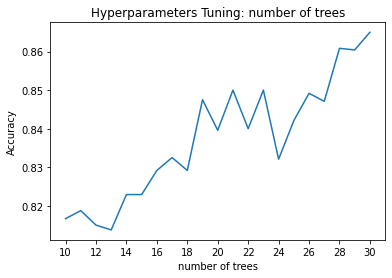

In [135]:
# Accuracy - n_tree plot
plt.figure()
plt.subplot()
plt.plot(num_trees,acc[0:21])
plt.xlabel('number of trees')
plt.ylabel('Accuracy')
plt.title('Hyperparameters Tuning: number of trees')
plt.xticks(range(10,31,2))

In [110]:
# Performance on unseen data######### this may be unnecessary!
acc_unseen = []

for i in range(10):
    
    accuracies = [] 
    skf = StratifiedKFold(n_splits=6)
    
    for train_idx, test_idx in skf.split(X_test_final, Y_test_final):
               
        X_train , X_test = X_test_final[train_idx] , X_test_final[test_idx]
        Y_train , Y_test = Y_cross[train_idx] , Y_cross[test_idx]

        progressive_learner = ProgressiveLearner(
            default_transformer_class=default_transformer_class,
            default_transformer_kwargs=default_transformer_kwargs,
            default_voter_class=default_voter_class,
            default_voter_kwargs=default_voter_kwargs,
            default_decider_class=default_decider_class,
        )
        train_start_time = time.time()
        progressive_learner.add_task(
            X=X_train,
            y=Y_train,
            task_id=0,
            num_transformers=21,
            transformer_voter_decider_split=[0.67, 0.33, 0],
            decider_kwargs={"classes": np.unique(Y_train)},
        )

        train_end_time = time.time()

        inference_start_time = time.time()
        task_0_predictions = progressive_learner.predict(X_test, task_id=0)
        inference_end_time = time.time()

        accuracies.append(np.mean(task_0_predictions == Y_test))
        train_times_across_tasks.append(train_end_time - train_start_time)
        inference_times_across_tasks.append(inference_end_time - inference_start_time)
        print('Current accuracies:',accuracies)
    acc.append(np.mean(accuracies))

Current accuracies: [0.08]
Current accuracies: [0.08, 0.11]
Current accuracies: [0.08, 0.11, 0.08]
Current accuracies: [0.08, 0.11, 0.08, 0.13]
Current accuracies: [0.08, 0.11, 0.08, 0.13, 0.08]
Current accuracies: [0.08, 0.11, 0.08, 0.13, 0.08, 0.16]
Current accuracies: [0.11]
Current accuracies: [0.11, 0.13]
Current accuracies: [0.11, 0.13, 0.16]
Current accuracies: [0.11, 0.13, 0.16, 0.07]


KeyboardInterrupt: 

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

acc_RandomForest = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.25)
    clf = RandomForestClassifier(n_estimators=19, max_depth=30)
    clf = clf.fit(X_train, y_train)
    Y_predict = clf.predict(X_test)
    accuracy=accuracy_score(Y_predict,y_test)
    #print('Accuracy_RandomForest: ',accuracy)
    acc_RandomForest.append(accuracy)

In [180]:
np.mean(acc_RandomForest)

0.9028533333333334

In [148]:
acc_proglean = []
for i in range(50):
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.25)
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
    )
    progressive_learner.add_task(
        X=X_train,
        y=Y_train,
        task_id=0,
        num_transformers=19,
        transformer_voter_decider_split=[0.67, 0.33, 0],
        decider_kwargs={"classes": np.unique(y_train)},
    )
    task_0_predictions = progressive_learner.predict(X_test, task_id=0)
    acc_proglean.append(np.mean(task_0_predictions == Y_test))
    #print(acc_proglean)


In [150]:
np.mean(acc_proglean)

0.84792

Text(0.5, 1.0, 'Comparison between L2F and RandomForest')

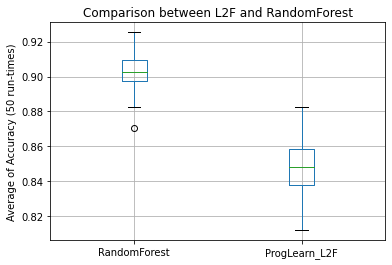

In [186]:
d = {'RandomForest': np.array(acc_RandomForest),
     'ProgLearn_L2F': np.array(acc_proglean)}
df = pd.DataFrame(data=d)
#boxplot = df.boxplot()
boxplot = df.boxplot(column=['RandomForest', 'ProgLearn_L2F'])
#plt.xlabel('Algorithm')
plt.ylabel('Average of Accuracy (50 run-times)')
plt.title('Comparison between L2F and RandomForest')


In [173]:
accuracies_across_tasks = []

for speaker in Label_speaker:
    index = np.where(Y_all_speaker==speaker)
    X = X_all[index]
    Y = Y_all[index]
    
    if speaker == 'g':
        default_transformer_class = TreeClassificationTransformer
        default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
        default_voter_class = TreeClassificationVoter
        default_voter_kwargs = {}
        default_decider_class = SimpleArgmaxAverage
        
        progressive_learner = ProgressiveLearner(
            default_transformer_class=default_transformer_class,
            default_transformer_kwargs=default_transformer_kwargs,
            default_voter_class=default_voter_class,
            default_voter_kwargs=default_voter_kwargs,
            default_decider_class=default_decider_class,
        )
        
        X_train0, X_test0, y_train0, y_test0 = train_test_split(X, Y, test_size=0.25)
        progressive_learner.add_task(
            X=X_train0,
            y=y_train0,
            task_id = 0,
            num_transformers= 19, ###ntree
            transformer_voter_decider_split=[0.67, 0.33, 0],
            decider_kwargs={"classes": np.unique(y_train0)},
        )
        task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
        accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
        print('Task1 finished, accuracy: ',accuracies_across_tasks)
    else:
        progressive_learner.add_transformer(
            X=X,
            y=Y,
            transformer_data_proportion=1,
            num_transformers=n_tree,
            backward_task_ids=[0],
        )
        task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
        accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
        print('Task1 finished, accuracy: ',accuracies_across_tasks)
    

Task1 finished, accuracy:  [0.92]
Task1 finished, accuracy:  [0.92, 0.928]
Task1 finished, accuracy:  [0.92, 0.928, 0.952]
Task1 finished, accuracy:  [0.92, 0.928, 0.952, 0.952]
Task1 finished, accuracy:  [0.92, 0.928, 0.952, 0.952, 0.952]
Task1 finished, accuracy:  [0.92, 0.928, 0.952, 0.952, 0.952, 0.952]


In [152]:
accuracies_across_tasks

[0.92, 0.968, 0.976, 0.976, 0.976, 0.976]

Text(0.5, 1.0, 'L2F')

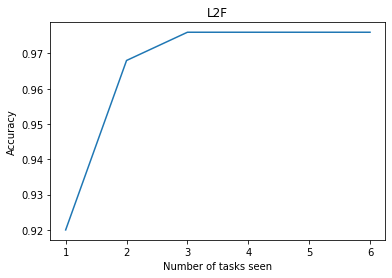

In [172]:
plt.figure()
plt.subplot()
plt.plot(range(1,7),accuracies_across_tasks)
plt.xlabel('Number of tasks seen')
plt.ylabel('Accuracy')
plt.title('L2F')
#plt.xticks(range(10,31,2))

Text(0.5, 1.0, 'L2F')

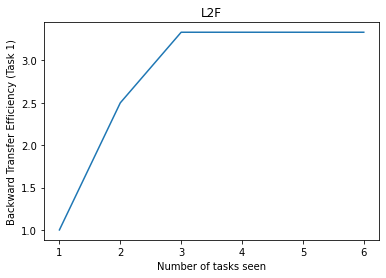

In [168]:
err = 1- np.array(accuracies_across_tasks)
bte = err[0]/err

plt.figure()
plt.subplot()
plt.plot(range(1,7),bte)
plt.xlabel('Number of tasks seen')
plt.ylabel('Backward Transfer Efficiency (Task 1)')
plt.title('L2F')


# Blocks below are for testing progLearn

In [92]:

accuracies_across_tasks = []
train_times_across_tasks = []
inference_times_across_tasks = []
#############
n_tree = 20
#############
#Task1
index = np.where(Y_all_speaker=='g')
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_all[index], Y_all[index], test_size=0.25)

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}
default_decider_class = SimpleArgmaxAverage

progressive_learner = ProgressiveLearner(
    default_transformer_class=default_transformer_class,
    default_transformer_kwargs=default_transformer_kwargs,
    default_voter_class=default_voter_class,
    default_voter_kwargs=default_voter_kwargs,
    default_decider_class=default_decider_class,
)
train_start_time = time.time()
progressive_learner.add_task(
    X=X_train0,
    y=y_train0,
    task_id = 0,
    num_transformers= n_tree, ###ntree
    transformer_voter_decider_split=[0.67, 0.33, 0],
    decider_kwargs={"classes": np.unique(y_train0)},
)

train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task1 finished, accuracy: ',accuracies_across_tasks)

###############################################################
index = np.where(Y_all_speaker=='j')
X_train, X_test, y_train, y_test = train_test_split(X_all[index], Y_all[index], test_size=0.1)
train_start_time = time.time()
progressive_learner.add_transformer(
    X=X_train,
    y=y_train,
    transformer_data_proportion=1,
    num_transformers=n_tree,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task2 finished, accuracy: ',accuracies_across_tasks)
#################################################################
index = np.where(Y_all_speaker=='l')
X_train, X_test, y_train, y_test = train_test_split(X_all[index], Y_all[index], test_size=0.1)
train_start_time = time.time()
progressive_learner.add_transformer(
    X=X_train,
    y=y_train,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task3 finished, accuracy: ',accuracies_across_tasks)
##################################################################
index = np.where(Y_all_speaker=='n')
X_train, X_test, y_train, y_test = train_test_split(X_all[index], Y_all[index], test_size=0.1)
train_start_time = time.time()
progressive_learner.add_transformer(
    X=X_train,
    y=y_train,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task4 finished, accuracy: ',accuracies_across_tasks)
#####################################################################
index = np.where(Y_all_speaker=='t')
X_train, X_test, y_train, y_test = train_test_split(X_all[index], Y_all[index], test_size=0.1)
train_start_time = time.time()
progressive_learner.add_transformer(
    X=X_train,
    y=y_train,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task5 finished, accuracy: ',accuracies_across_tasks)
########################################################################
index = np.where(Y_all_speaker=='y')
X_train, X_test, y_train, y_test = train_test_split(X_all[index], Y_all[index], test_size=0.1)
train_start_time = time.time()
progressive_learner.add_transformer(
    X=X_train,
    y=y_train,
    transformer_data_proportion=1,
    num_transformers=20,
    backward_task_ids=[0],
)
train_end_time = time.time()

inference_start_time = time.time()
task_0_predictions = progressive_learner.predict(X_test0, task_id=0)
inference_end_time = time.time()

accuracies_across_tasks.append(np.mean(task_0_predictions == y_test0))
train_times_across_tasks.append(train_end_time - train_start_time)
inference_times_across_tasks.append(inference_end_time - inference_start_time)

print('Task6 finished, accuracy: ',accuracies_across_tasks)

Task1 finished, accuracy:  [0.896]
Task2 finished, accuracy:  [0.896, 0.912]
Task3 finished, accuracy:  [0.896, 0.912, 0.912]
Task4 finished, accuracy:  [0.896, 0.912, 0.912, 0.912]
Task5 finished, accuracy:  [0.896, 0.912, 0.912, 0.912, 0.92]
Task6 finished, accuracy:  [0.896, 0.912, 0.912, 0.912, 0.92, 0.928]
